In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import sparse,  io, linalg
import pickle
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import snap


def plot_log_log(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([np.log(r) for r in records[:,0]], [np.log(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
def plot(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([(r) for r in records[:,0]], [(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
    
def plot_log_log_median(records,B=20,discrete=False):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]


    xs = [np.log(record[0]) for record in records]
    ys = [np.log(record[1]) for record in records]
    if discrete==False:
        x_max = max(xs) - min(xs)
        # bin into default 20 values
        binned_xs = [min(xs)+(x_max*i)/float(B) for i in range(B+1)]
        median_ys = []
        err = []
        for i in range(B):
            # find median y values for x values in [binned_xs[i], binned_xs[i+1])
            current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
            current_y = np.median(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
            plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err)
    else:
        binned_xs = np.unique(xs)
        median_ys = []
        err = []
        for x in binned_xs:
            current_ys = [ys[j] for j in range(len(xs)) if xs[j] == x]
            current_y = np.median(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs, median_ys, marker='o', yerr=err)


    
    
    
def plot_median(records,B=20):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    xs = [(record[0]) for record in records]
    ys = [(record[1]) for record in records]
    x_max = max(xs)
    # bin into default 20 values
    binned_xs = [x_max*i/float(B) for i in range(B+1)]
    median_ys = []
    err = []
    for i in range(B):
        # find median y values for x values in [binned_xs[i], binned_xs[i+1])
        current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
        current_y = np.median(current_ys)
        median_ys += [current_y]
        #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
        err += [np.std(current_ys)]
    plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err)




In [50]:
G1=nx.read_adjlist('../oregon/oregon1_010331.txt',nodetype=int)
G2=nx.read_adjlist('../oregon/oregon1_010407.txt',nodetype=int)

In [36]:
D=6
records = []
#random_nodes=np.random.choice(G.nodes(),size=10)
#np.random.randint(len(G.nodes()),size=100)
for node in tqdm(G.nodes()):
    for d in range(1,D):
        records += [(d,len(nx.single_source_shortest_path_length(G,node,cutoff=d)))]
records = np.asarray(records)
        

KeyboardInterrupt: 

In [31]:
np.save('../oregon/self-similarity',records)

<IPython.core.display.Javascript object>


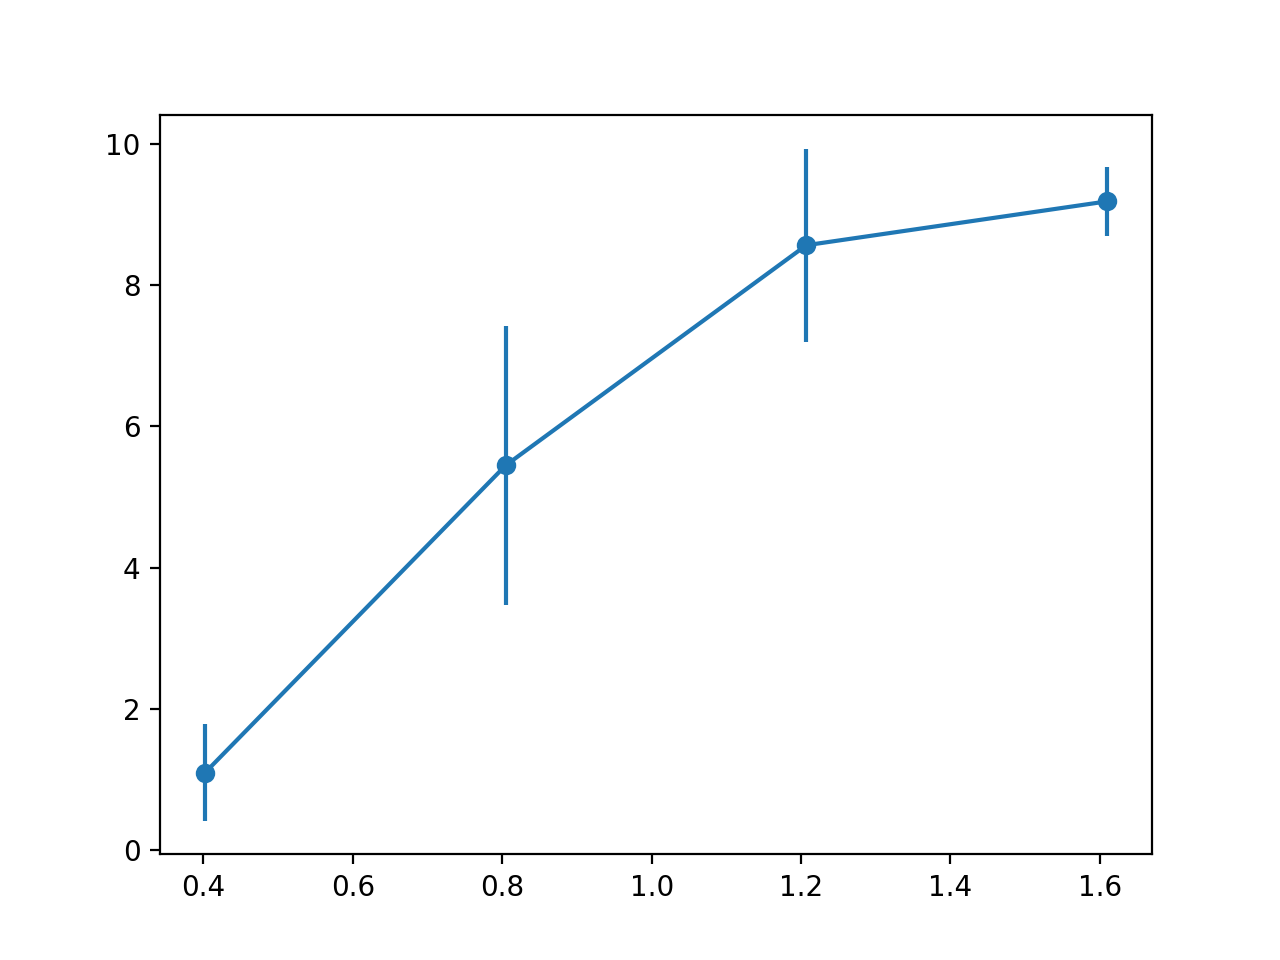

In [37]:
records = np.asarray(records)
plot_log_log_median(records,B=4)

In [3]:
college_messages = np.loadtxt('../CollegeMsg.txt',dtype=int)


In [69]:
# converting edge weight information into graph
college_messages_G = nx.Graph()
for i in tqdm(range(college_messages.shape[0])):
    if college_messages_G.has_edge(college_messages[i,0],college_messages[i,1]):
        college_messages_G[college_messages[i,0]][college_messages[i,1]]['weight']+=1
    else:
        college_messages_G.add_edge(college_messages[i,0],college_messages[i,1],weight=1)


In [70]:
for e in tqdm(college_messages_G.edges()):
    college_messages_G[e[0]][e[1]]['weight']=np.exp(-float(college_messages_G[e[0]][e[1]]['weight'])/5.0)

In [55]:
#mutual neighbors
pwl = []
for e in tqdm(college_messages_G.edges()):
    wt = college_messages_G[e[0]][e[1]]['weight']/np.sqrt(college_messages_G.degree(e[0],weight='weight')*college_messages_G.degree(e[1],weight='weight'))
    nbr1 = set(college_messages_G.neighbors(e[0]))
    nbr2 = set(college_messages_G.neighbors(e[1]))
    common_nbrs= set.intersection(nbr1,nbr2)
    #score = sum([1/np.log(len(college_messages_G.neighbors(v))) for v in common_nbrs])
    score = len(set.intersection(nbr1,nbr2))/float(len(set.union(nbr1,nbr2)))
    #score = len(set.intersection(nbr1,nbr2)
    pwl += [(wt, score)]

<IPython.core.display.Javascript object>


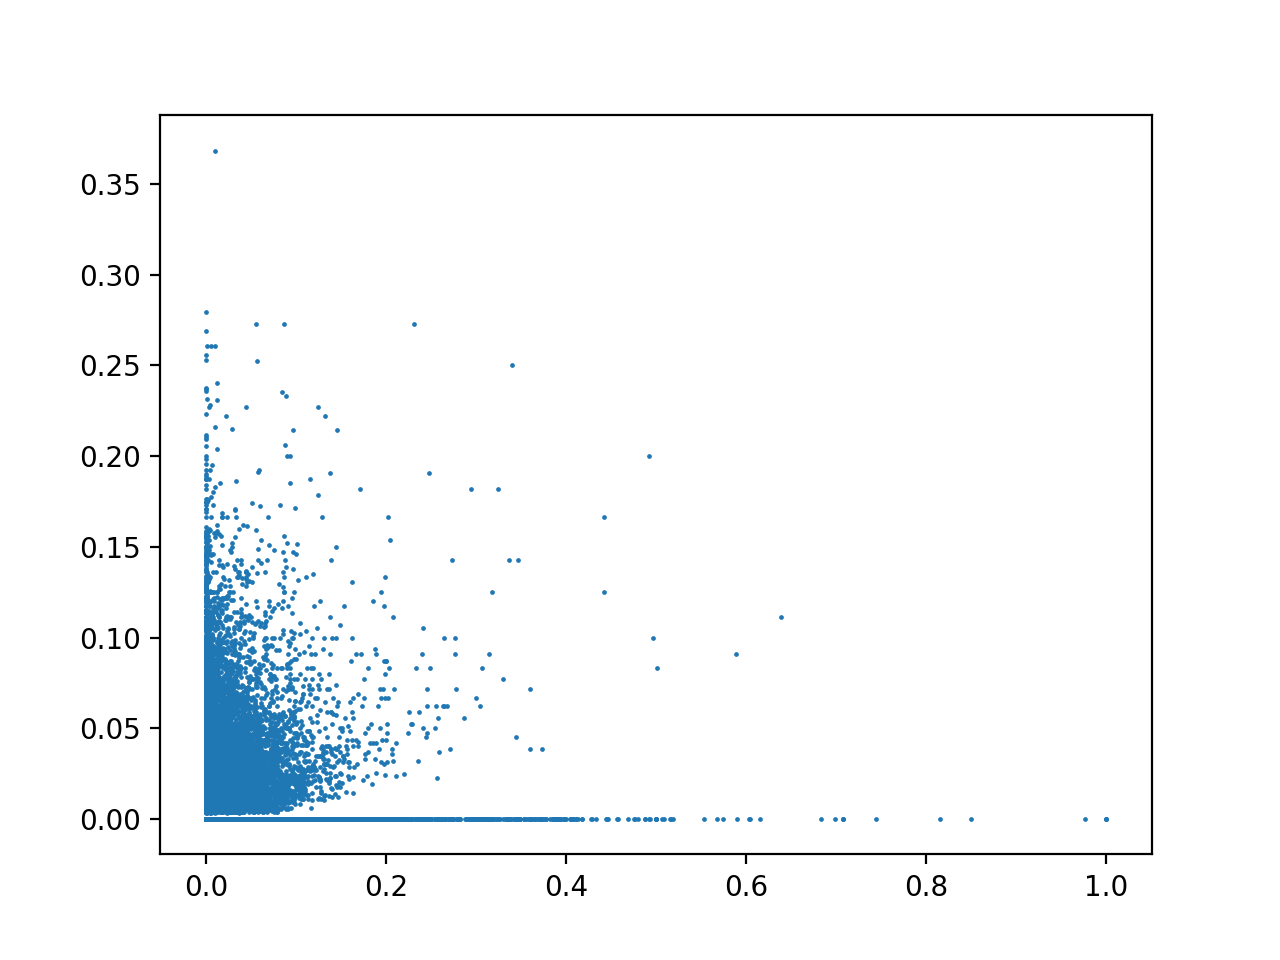

<IPython.core.display.Javascript object>


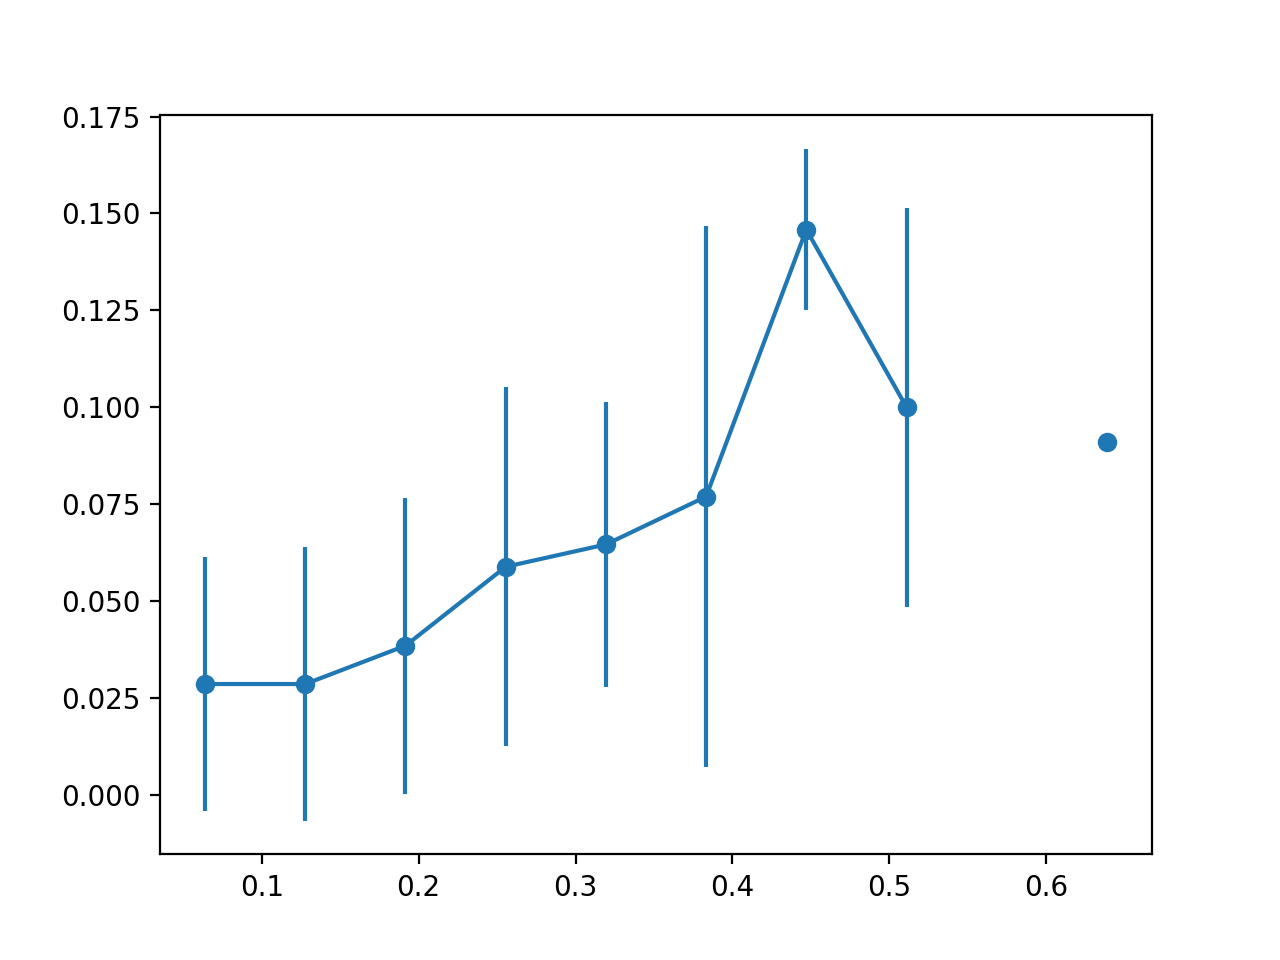

In [58]:
fig, ax = plt.subplots()
pwl=np.asarray(pwl)
plt.scatter([r for r in pwl[:,0]], [r for r in  pwl[:,1]],s=0.5)
plot_median(pwl,B=10)
#plot_log_log(pwl)
#plot_log_log_median(pwl,B=7)
#pwl

In [71]:
college_messages_G[1]

{2: {'weight': 0.81873075307798182},
 3: {'weight': 1.515144112143249e-06},
 30: {'weight': 0.36787944117144233},
 32: {'weight': 0.67032004603563933},
 36: {'weight': 0.027323722447292559},
 42: {'weight': 0.20189651799465538},
 44: {'weight': 0.16529888822158653},
 101: {'weight': 0.81873075307798182},
 123: {'weight': 0.67032004603563933},
 132: {'weight': 0.30119421191220214},
 135: {'weight': 0.5488116360940265},
 146: {'weight': 0.1353352832366127},
 159: {'weight': 0.67032004603563933},
 161: {'weight': 0.1353352832366127},
 194: {'weight': 0.81873075307798182},
 211: {'weight': 0.20189651799465538},
 255: {'weight': 0.44932896411722156},
 281: {'weight': 0.67032004603563933},
 302: {'weight': 0.5488116360940265},
 312: {'weight': 1.8601939266915511e-08},
 313: {'weight': 0.81873075307798182},
 323: {'weight': 0.81873075307798182},
 397: {'weight': 0.81873075307798182},
 477: {'weight': 0.018315638888734179},
 652: {'weight': 0.5488116360940265},
 856: {'weight': 0.6703200460356

In [72]:
pwl = []
for node in tqdm(college_messages_G.nodes()):
    for d in [0.01,0.1,0.2,0.4,0.8]:
        pwl += [(d,len(nx.single_source_dijkstra_path_length(college_messages_G,node,cutoff=d,weight='weight')))]
pwl=np.asarray(pwl)

<IPython.core.display.Javascript object>


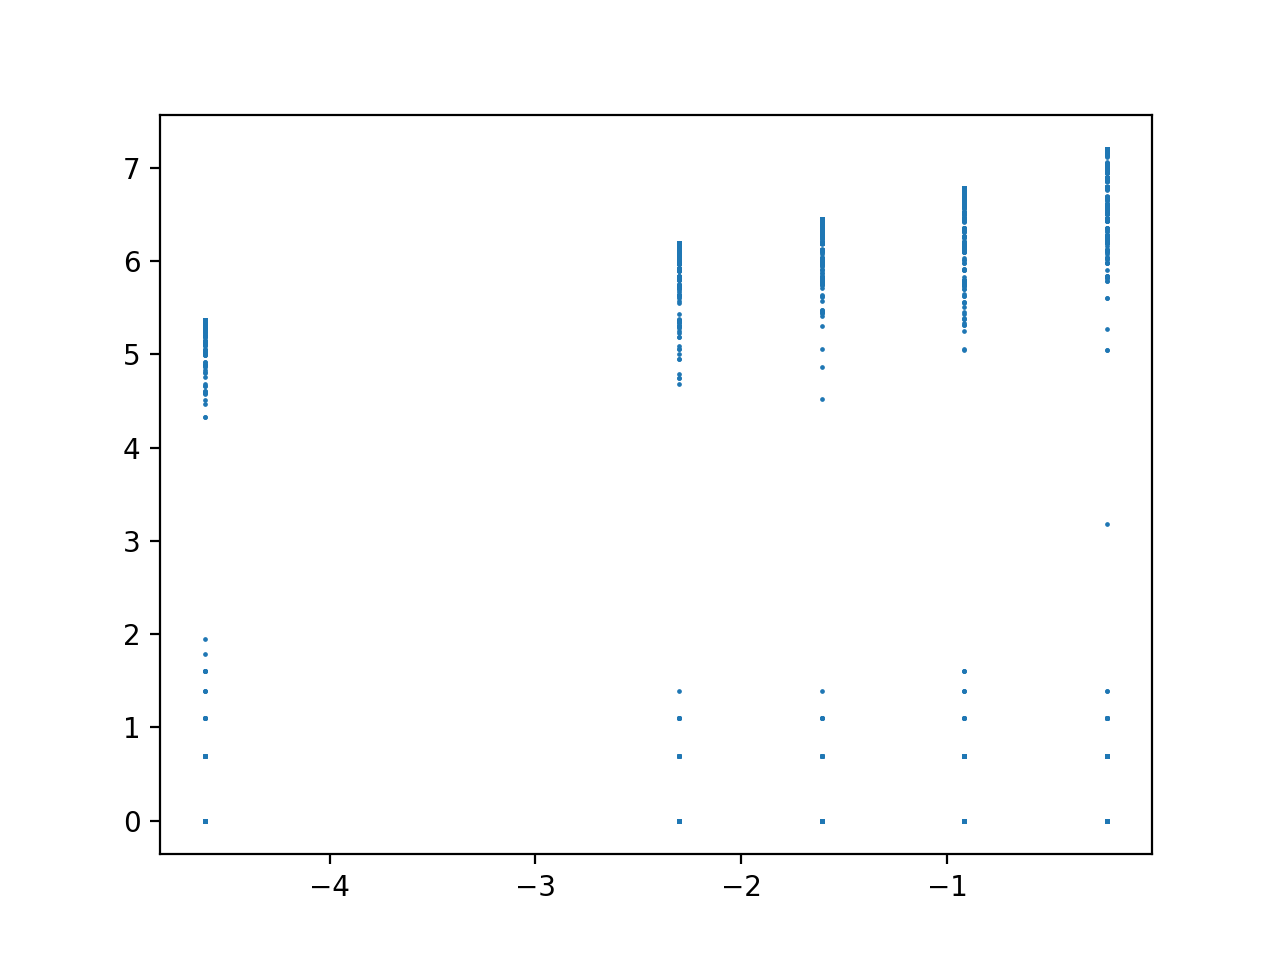

<IPython.core.display.Javascript object>


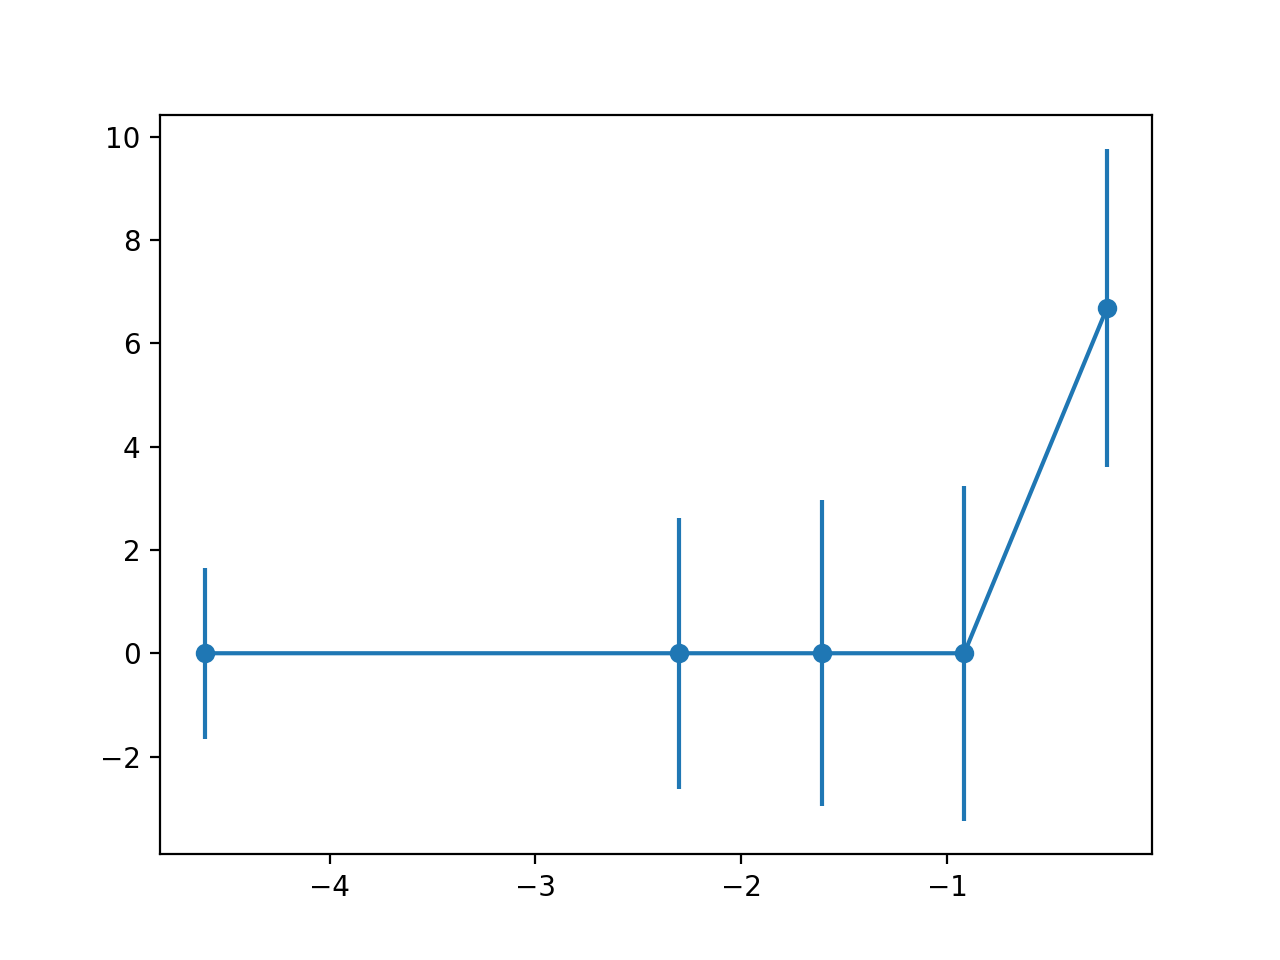

In [73]:
plot_log_log(np.asarray(pwl))
plot_log_log_median(pwl,discrete=True)